In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib
import os
import cv2
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Flatten
from tensorflow.keras import Input, Model
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')


GPU is available
Number of available GPUs: 1
GPU 0: {'device_name': 'NVIDIA GeForce RTX 3060 Ti', 'compute_capability': (8, 6)}


In [3]:
train = r'D:\Brain Cancer\Dataset\Brain_Cancer_processed_train_test\train_augmented'
val = r'D:\Brain Cancer\Dataset\Brain_Cancer_processed_train_test\val'
test = r'D:\Brain Cancer\Dataset\Brain_Cancer_processed_train_test\test'

import os

print(os.listdir(train))
print(os.listdir(val))
print(os.listdir(test))

['brain_glioma', 'brain_menin', 'brain_tumor']
['brain_glioma', 'brain_menin', 'brain_tumor']
['brain_glioma', 'brain_menin', 'brain_tumor']


In [4]:
tf.random.set_seed(42)

train_set = keras.utils.image_dataset_from_directory(train, seed = 1, shuffle = True, batch_size = 128, image_size=(128,128))

val_set = keras.utils.image_dataset_from_directory(val, seed = 1, shuffle = True, batch_size = 16, image_size=(128,128))

test_set = keras.utils.image_dataset_from_directory(test, seed = 1, shuffle = True, batch_size = 16, image_size=(128,128))

Found 24220 files belonging to 3 classes.
Found 606 files belonging to 3 classes.
Found 606 files belonging to 3 classes.


In [5]:
filenames = pathlib.Path(train)
for label in train_set.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

brain_glioma : 7895
brain_menin : 8060
brain_tumor : 8265


In [6]:
filenames = pathlib.Path(val)
for label in val_set.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

brain_glioma : 216
brain_menin : 175
brain_tumor : 215


In [7]:
filenames = pathlib.Path(test)
for label in test_set.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

brain_glioma : 209
brain_menin : 217
brain_tumor : 180


In [8]:
train_set.cardinality().numpy(), val_set.cardinality().numpy(), test_set.cardinality().numpy()

(190, 38, 38)

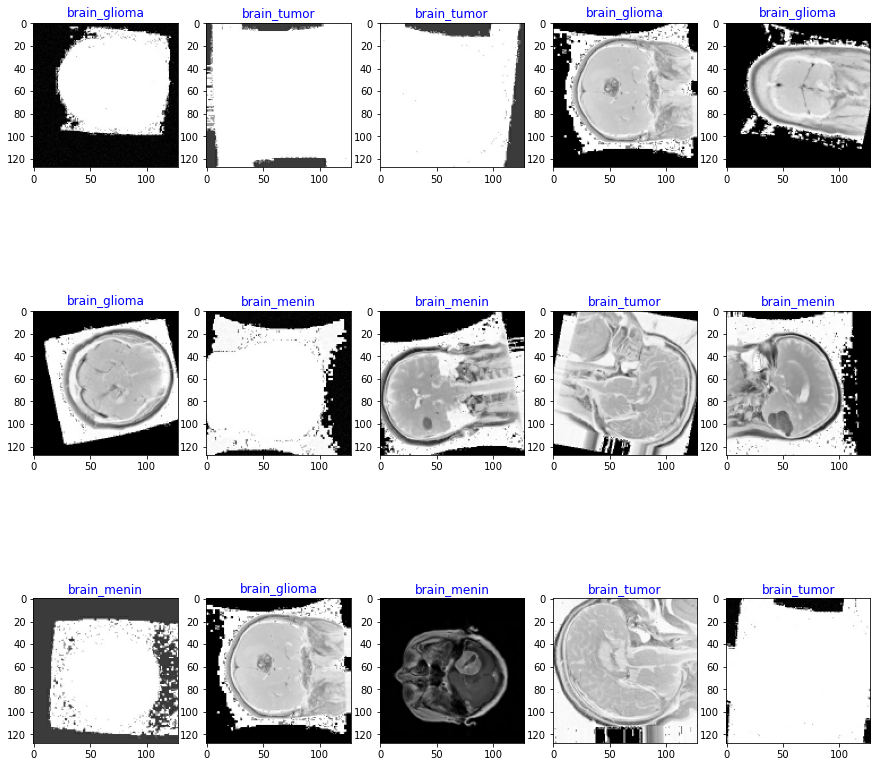

In [9]:
# print random images from the train set
plt.figure(figsize = (15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[index]], color= 'blue', fontsize= 12)
        plt.axis(True)
plt.show()

In [10]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(128, 128, 128, 3)
(128,)


In [11]:
from tensorflow.keras.applications import VGG16

In [12]:
vgg16Model = VGG16(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [13]:
vgg16Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [14]:
vgg16Model.trainable = True

In [15]:
tf.random.set_seed(42)

X = vgg16Model.output

X = Flatten()(X)

X = Dropout(0.5)(X)
X = Dense(1024, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.25)(X)

output_layer = Dense(4, activation='softmax')(X)

model2 = Model(inputs = vgg16Model.input, outputs = output_layer)

In [16]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [17]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [18]:
history_2 = model2.fit(train_set, epochs=30, validation_data=val_set)

Epoch 1/30
190/190 [==============================] - 68s 331ms/step - loss: 1.1609 - accuracy: 0.5196 - val_loss: 0.6410 - val_accuracy: 0.7112
Epoch 2/30
190/190 [==============================] - 67s 350ms/step - loss: 0.6230 - accuracy: 0.7312 - val_loss: 0.2874 - val_accuracy: 0.9026
Epoch 3/30
190/190 [==============================] - 68s 356ms/step - loss: 0.4279 - accuracy: 0.8249 - val_loss: 0.2501 - val_accuracy: 0.8960
Epoch 4/30
190/190 [==============================] - 68s 356ms/step - loss: 0.3246 - accuracy: 0.8701 - val_loss: 0.1758 - val_accuracy: 0.9340
Epoch 5/30
190/190 [==============================] - 69s 363ms/step - loss: 0.2559 - accuracy: 0.8987 - val_loss: 0.2008 - val_accuracy: 0.9389
Epoch 6/30
190/190 [==============================] - 69s 362ms/step - loss: 0.2065 - accuracy: 0.9206 - val_loss: 0.1583 - val_accuracy: 0.9538
Epoch 7/30
190/190 [==============================] - 72s 376ms/step - loss: 0.1490 - accuracy: 0.9435 - val_loss: 0.1801 - val_ac

In [19]:
# Save the model
#model2.save('d:\\Balanced Augmented Covid CXR Dataset\\Model\\vgg16Model.h5')

In [20]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
        # Specify the directory to save the PDF
    save_dir = 'D:\\Brain Cancer\\PDF'
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Full path to save the PDF file
    pdf_path = os.path.join(save_dir, 'VGG16_3_training_curves.pdf')
    
    # Save the plot as a PDF with tight layout
    plt.tight_layout()  # Ensure that layout is tight
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight')  
    # Show the plot
    plt.show()

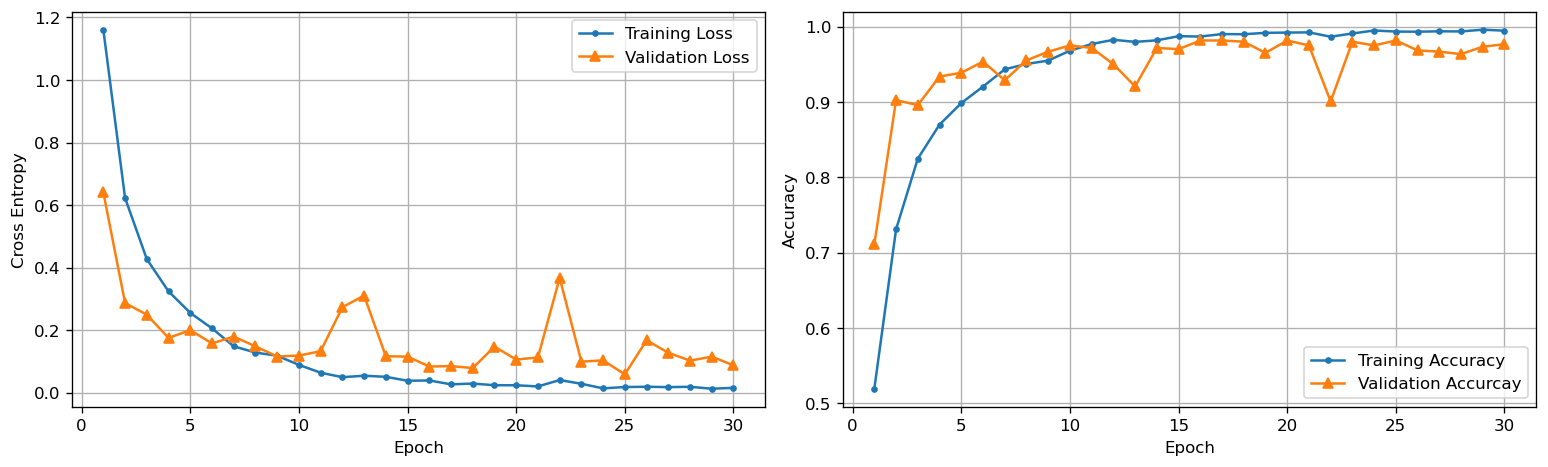

In [21]:
plot_training_curves(pd.DataFrame(history_2.history))

In [22]:
X_test, y_test = None, None
for images, labels in test_set:
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)
        
X_test.shape, y_test.shape

(TensorShape([606, 128, 128, 3]), TensorShape([606]))

In [23]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [24]:
test_score = model2.evaluate(test_set, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

38/38 [==============================] - 1s 15ms/step - loss: 0.0454 - accuracy: 0.9917
Test Loss:  0.045406971126794815
Test Accuracy:  0.9917491674423218


In [25]:
target_names = ['brain_glioma', 'brain_menin', 'brain_tumor']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

brain_glioma       1.00      0.99      1.00       209
 brain_menin       0.99      0.99      0.99       217
 brain_tumor       0.99      0.99      0.99       180

    accuracy                           0.99       606
   macro avg       0.99      0.99      0.99       606
weighted avg       0.99      0.99      0.99       606



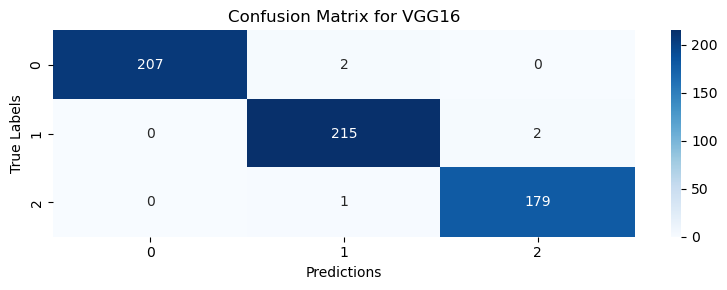

In [36]:
import seaborn as sns
plt.figure(figsize = (8,3), dpi = 100)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True, fmt='d', cmap = 'Blues')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
    # Add a title with the model name VGG19_2
plt.title('Confusion Matrix for VGG16')

    # Specify the directory to save the PDF
save_dir = 'D:\\Brain Cancer\\PDF'
    
    # Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

    # Full path to save the PDF file (with VGG19_2 in the filename)
pdf_path = os.path.join(save_dir, 'VGG16_3_confusion_matrix.pdf')
    
    # Save the plot as a PDF with tight layout
plt.tight_layout()  # Ensure that layout is tight
plt.savefig(pdf_path, format='pdf', bbox_inches='tight')

plt.show()

In [27]:
# plot random images from a given dataset, and compare predictions with ground truth
def plot_random_predictions(dataset, model):

    shuffled_data = dataset.shuffle(10)
    class_names = dataset.class_names

    for images, labels in shuffled_data.take(1):
        plt.figure(figsize = (10, 10), dpi = 120)
        y_pred_proba = model.predict(images)

    for i in range(9):
        index = random.randint(0, len(images))
        ax = plt.subplot(3,3, i + 1)

        img = images[index].numpy().astype("uint8")
        y_true = class_names[labels[index]]
        y_pred = class_names[np.argmax(y_pred_proba[index], axis = 0)]
      
        c = 'g' if y_pred == y_true else 'r'
      
        plt.imshow(img)
        plt.title(f'Predicted : {y_pred}\nTrue label : {y_true}', c = c)
        plt.axis(False)

InvalidArgumentError: slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

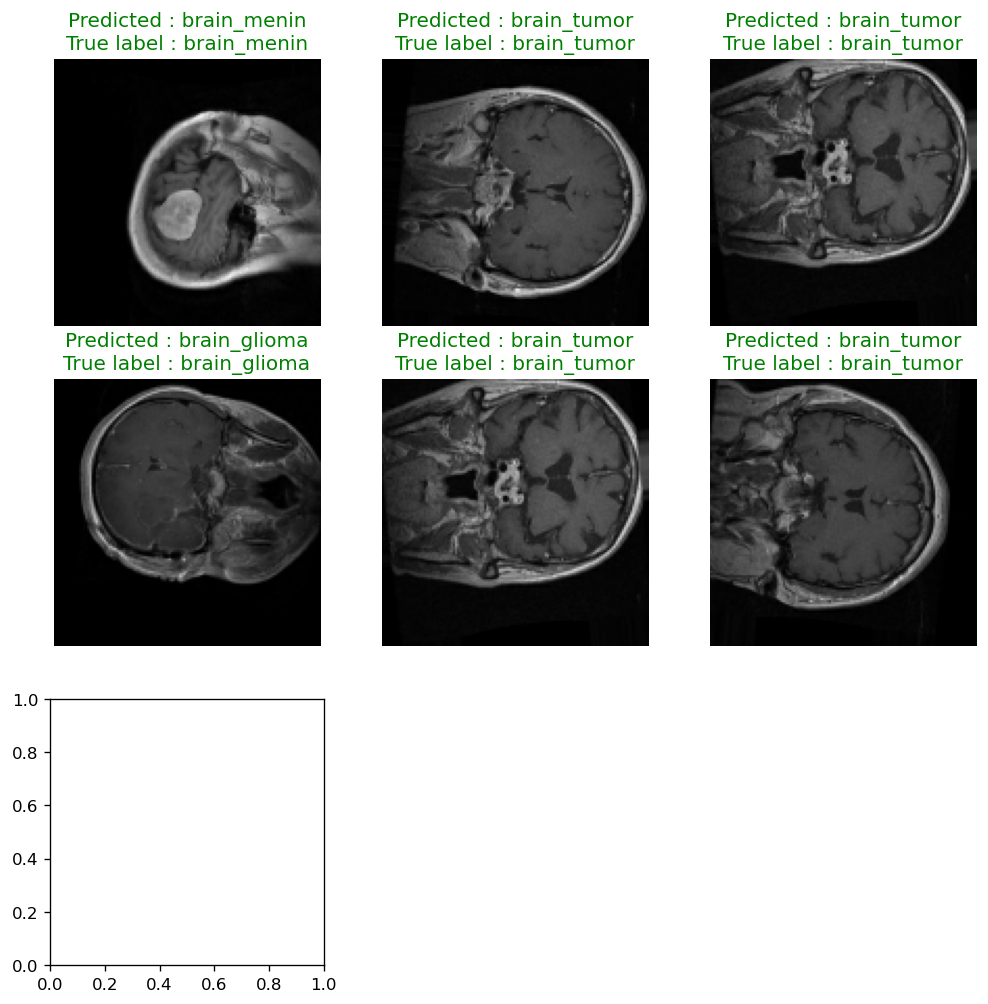

In [28]:
plot_random_predictions(test_set, model2)

Gradcam

In [69]:
# Function to save and display GradCAM
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\Brain Cancer\PDF\VGG16_gradcam_brain_menin_0143.pdf')  # Save as pdf format
    plt.show()

In [70]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

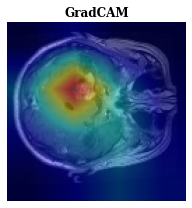

In [71]:
 # make a prediction and visualize grad-cam
def make_prediction_and_visualize_():
    img_path = r'D:\Brain Cancer\Dataset\Brain_Cancer raw MRI data\Brain_Cancer\brain_menin\brain_menin_0143.jpg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128)) #IMG_WIDTH, IMG_HEIGHT
    batch_pred = np.expand_dims(img, 0)

    #rescaled_img = img / 255.0
    #batch_pred = np.expand_dims(rescaled_img, 0)


    last_conv_layer_name = 'block5_pool'

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, model2, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)


make_prediction_and_visualize_()

Gradcam++

In [72]:
# Function to save and display ScoreCAM
def save_and_display_gradcam_plusplus(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM++', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\Brain Cancer\PDF\VGG16_gradcam++_brain_menin_0143.pdf')  # Save as pdf format
    plt.show()

In [73]:
# Function to generate GradCAM++ heatmap
def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get gradients
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Calculate guided gradients
    guided_grads = tf.cast(last_conv_layer_output > 0, 'float32') * grads[0]

    # Calculate importance weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Generate heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()

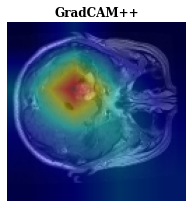

In [74]:
# Function to make a prediction and visualize GradCAM++
def make_prediction_and_visualize_gradcam_plusplus():
    img_path = r'D:\Brain Cancer\Dataset\Brain_Cancer raw MRI data\Brain_Cancer\brain_menin\brain_menin_0143.jpg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize image to match model input size

    batch_pred = np.expand_dims(img, 0)

    last_conv_layer_name = 'block5_pool'

    # Generate GradCAM++ heatmap
    heatmap = make_gradcam_plusplus_heatmap(batch_pred, model2, last_conv_layer_name)

    save_and_display_gradcam_plusplus(img_path, heatmap)

make_prediction_and_visualize_gradcam_plusplus()